In [193]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr

In [246]:
df = pd.read_csv('dataset.csv')
# transform commits to log scale
df["language"], languages = pd.factorize(df["language"])
df["project_type"], project_types = pd.factorize(df["project_type"])

## TODO

- POISSON??
- Make DAG Fork 
- Prior Predictive Checks
- Comment On Checks
- Posterior Predictive Checks
- Plots, 

In [247]:
df.head()

,project,language,commits,insertions,age,bugs,project_type,devs,p
0,4clojure,Clojure,629,9180,774,128,Application,21,0.203498
1,4clojure,Javascript,75,39240,509,29,Application,10,0.386667
2,AFIncrementalStore,Objective-C,196,5624,362,74,Library,24,0.377551
3,AFNetworking,Objective-C,952,50099,962,403,Framework,128,0.423319
4,ActionBar-PullToRefresh,Java,213,14657,192,68,Library,5,0.319249


In [292]:

def language_and_betas(df):
      # specify coords:
      with pm.Model() as model:

            alpha = pm.Normal("alpha", mu=0, sigma=1) # 7
            
            beta_project_type = pm.Normal("beta_project_type", mu=0, sigma=1, shape = len(np.unique(df.project_type)))
            
            beta_language = pm.Normal("beta_language", mu=0, sigma=1, shape = len(np.unique(df.language)))
            
            language_ids = pm.Data("language_ids", df.language.values, mutable=True)

            p = pm.Deterministic("p", pm.math.invlogit(alpha + beta_project_type[df.project_type]*df.project_type + beta_language[df.language]*df.language))
            
            # likelihood
            y_i = pm.Binomial("y", n=df.commits, p=p, observed=df.bugs)
            trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)

      return trace, model
 

def baseline_alphas_per_language(df):
      with pm.Model() as model:

            alpha = pm.Normal("alpha", mu=0, sigma=1)
            beta_language = pm.Normal("beta_language", mu=0, sigma=1, shape = len(np.unique(df.language)))
            
            language_ids = pm.Data("language_ids", df.language.values, mutable=True)
      
            p = pm.Deterministic("p", pm.math.invlogit(alpha + beta_language[df.language]))

            # likelihood
            y_i = pm.Binomial("y", n=df.commits, p=p, observed=df.bugs)
            trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)

      return trace, model

In [293]:
BL_BPT_ = language_and_betas(df)
BL = baseline_alphas_per_language(df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_project_type, beta_language]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_language]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# inspection of model

In [294]:
pm.summary(BL_BPT_[0], var_names=["beta_project_type"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_project_type[0],0.019,0.989,-1.895,1.824,0.012,0.012,6467.0,5498.0,1.0
beta_project_type[1],0.178,0.007,0.165,0.191,0.000,0.000,3666.0,4588.0,1.0
beta_project_type[2],0.146,0.003,0.140,0.152,0.000,0.000,3580.0,5086.0,1.0
beta_project_type[3],0.039,0.003,0.033,0.045,0.000,0.000,4580.0,5492.0,1.0
beta_project_type[4],0.076,0.002,0.072,0.080,0.000,0.000,4354.0,5126.0,1.0
beta_project_type[5],0.050,0.002,0.047,0.053,0.000,0.000,4081.0,4863.0,1.0
beta_project_type[6],0.017,0.001,0.014,0.019,0.000,0.000,3639.0,5176.0,1.0


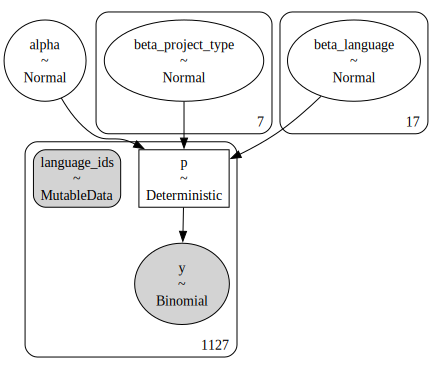

In [296]:
pm.model_to_graphviz(model=BL_BPT_[1])

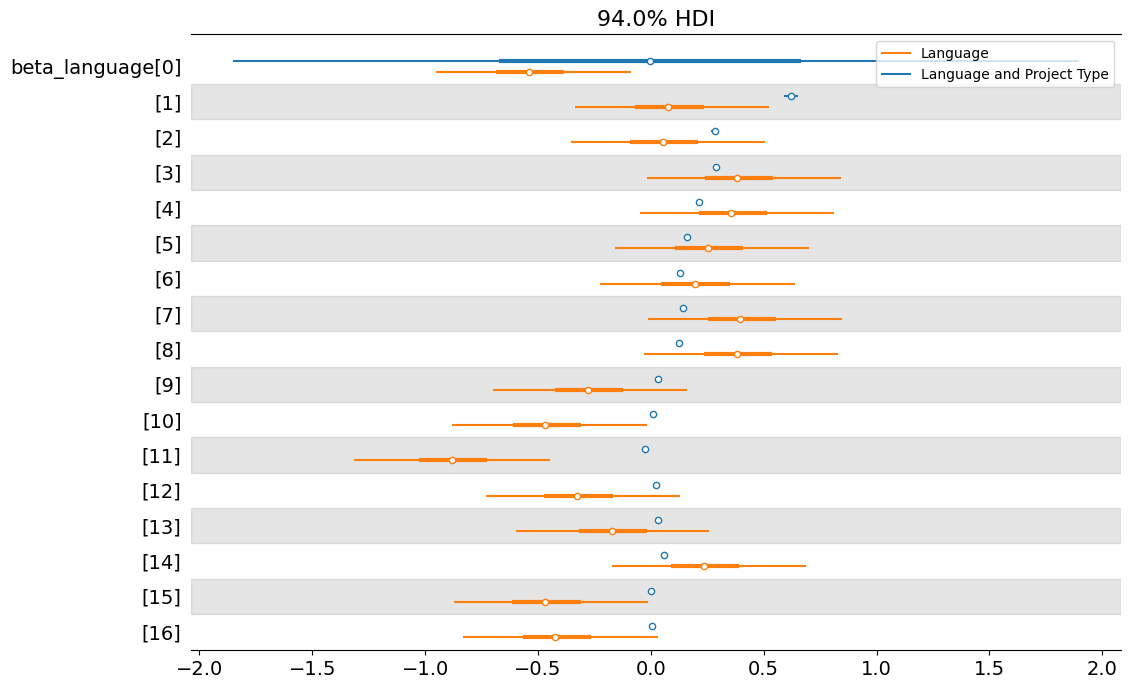

In [295]:
az.plot_forest([BL_BPT_[0],BL[0]], model_names=["Language and Project Type","Language"], var_names=["beta_language"], combined=True, figsize=(12, 8));

## FORK!!!!!!!


## Inference